In [1]:
%load_ext autoreload
%autoreload 2

## Introduction 
This example shows how to perform fault diagnosis of a rolling element bearing based on acceleration signals, especially in the presence of strong masking signals from other machine components. The example will use  envelope spectrum analysis and spectral kurtosis to diagnose bearing faults.

A bearing fault dataset has been provided to facilitate research into bearing analysis. The dataset comprises data from a bearing test rig (nominal bearing data, an outer race fault at various loads, and inner race fault and various loads), and three real-world faults.

Localized faults in a rolling element bearing may occur in the outer race, the inner race, the cage, or a rolling element. High frequency resonances between the bearing and the response transducer are excited when the rolling elements strike a local fault on the outer or inner race, or a fault on a rolling element strikes the outer or inner race  The following picture shows a rolling element striking a local fault at the inner race. The problem is how to detect and identify the various types of faults.


## Import

In [2]:
import matplotlib.pyplot as plt
from rul_pm.dataset.MFPT import MFPTDataset, BPFO, BPFI, FTF
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.signal

from sklearn.model_selection import train_test_split

sns.set()

In [3]:
from rul_pm.transformation.transformers import Transformer
from rul_pm.transformation.features.selection import ByNameFeatureSelector
from rul_pm.transformation.features.transformation import (
    SplitIntoWindows, Windowed,  Envelope,
    ConcatenateWindows)
from rul_pm.transformation.features.extraction import (
    LifeStatistics)
from rul_pm.transformation.features.denoising import (
    KurtogramBandPassFiltering)
from rul_pm.transformation.utils.kurtogram import (
    fast_kurtogram)
from rul_pm.transformation.target import TargetSplitIntoWindows
from rul_pm.graphics.kurtogram import plot_kurtogram


## Loading data
The dataset is already present in the library through the class MFPTDataset

In [4]:
dataset = MFPTDataset()

### Number of lives in the dataset

In [5]:
len(dataset)

20

### Train-test split

In [6]:
train_dataset, test_dataset = train_test_split(dataset, train_size=0.85)

print(f'Number of lives in the training set: {len(train_dataset)}')
print(f'Number of lives in the test set: {len(test_dataset)}')


Number of lives in the training set: 17
Number of lives in the test set: 3


## Feature extraction
Let's create two transformer, one that will use only raw signal as input.
The other one will compute the envelope of the signal and then extract features from the envelope

. Yes, the ideia is to split the signal in pieces, filter in a band, compute the hilbert transform and after the that the abs of this analytic signal

### Envelope pipeline
Following this idea we will create a transform that will perform the followin steps:
* split the signal in 2048 samples with an stride of 1024 samples
* for each of those window
    * a band-pass filtering will be aplied, the frequencies will be obtained from the kurtogram
    * Then the envelope will be compute
    * From the envelope, several features will be computed.
    
A brief example on the signal transformation procedure that will be applied to the signal:

#### Feature extraction example

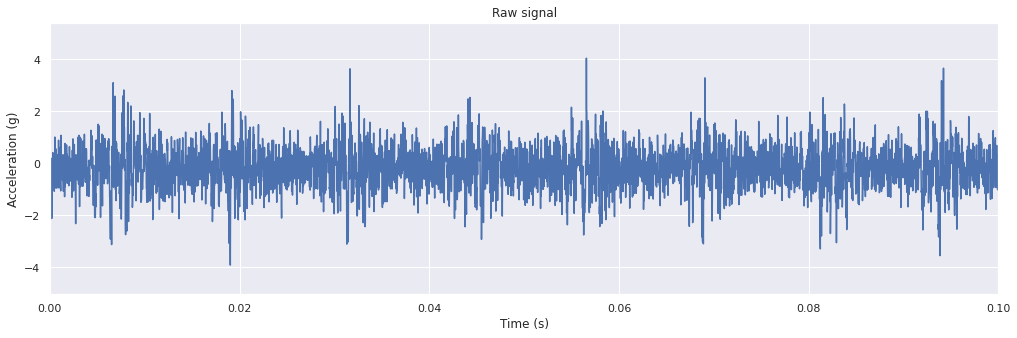

In [7]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(dataset[8]['time'], dataset[8]['gs'])
ax.set_xlim(0, 0.1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Acceleration (g)');
ax.set_title('Raw signal');

##### Kurtogram
From the raw signal a kurtogram is computed to obatinthe frequency band that has the highest kurtosis.

Kurtogram and spectral kurtosis compute kurtosis locally within frequency bands. They are powerful tools to locate the frequency band that has the highest kurtosis (or the highest signal-to-noise ratio) [2]. After pinpointing the frequency band with the highest kurtosis, a bandpass filter can be applied to the raw signal to obtain a more impulsive signal for envelope spectrum analysis.

In [8]:
fs = (dataset[2]['sr'].iloc[0])
N = dataset[2]['sr'].shape[0]
Kwav, freq, Level_w, BW, fc = fast_kurtogram(dataset[2]['gs'].values[:N], fs, 9)

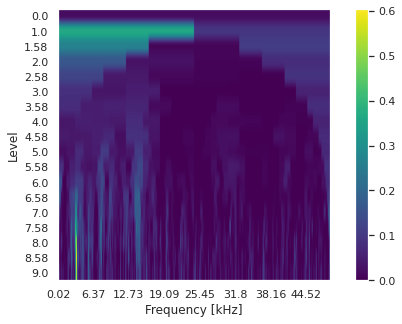

In [9]:
plot_kurtogram(Kwav, freq, Level_w);

##### Envelope
With the upper and lower bound of the frequency band, we can peform a band-pass filter to maximize the kurtosis of the signal.


In [10]:
from scipy.signal import hilbert, detrend

lw = fc - BW/2
up = fc + BW/2
    
taps_hamming = scipy.signal.firwin(200, 
                                  [lw, up], 
                                  pass_zero='bandpass',
                                  window='hamming', 
                                  scale=False, 
                                  fs=fs)
envelope = Envelope()
#x = detrend(dataset[2]['gs'].values[:N], type='constant')
x = dataset[2]['gs'].values[:N]
filtered = scipy.signal.lfilter(taps_hamming, fs, x)





(0.0, 0.1)

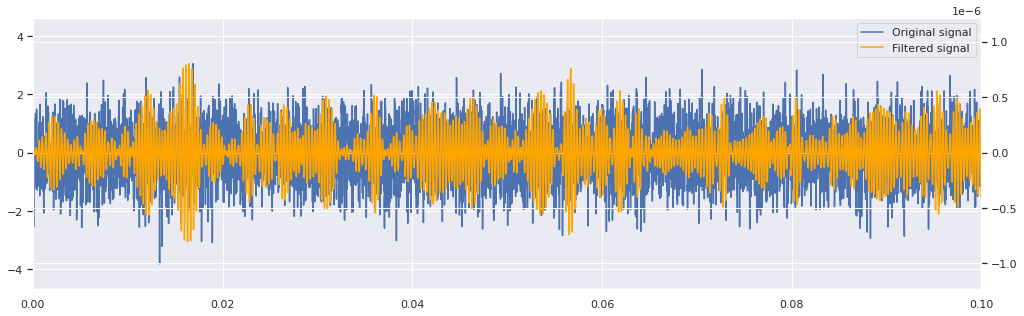

In [11]:
fig, ax = plt.subplots(1,1, figsize=(17, 5))
line1 = ax.plot(dataset[2]['time'].iloc[:N], dataset[2]['gs'].iloc[:N], label='Original signal')
ax2 = ax.twinx()
line2 = ax2.plot(dataset[2]['time'].iloc[:N], filtered, color='orange', label='Filtered signal')

lns = line1+line2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=1)
ax.set_xlim(0,0.1)

After filtering the signal we can compute the envelope trought the ilbert transform

In [12]:
analytic_signal = hilbert(filtered) 
amplitude_envelope = np.abs(analytic_signal)
amplitude_envelope = detrend(amplitude_envelope, type='constant')

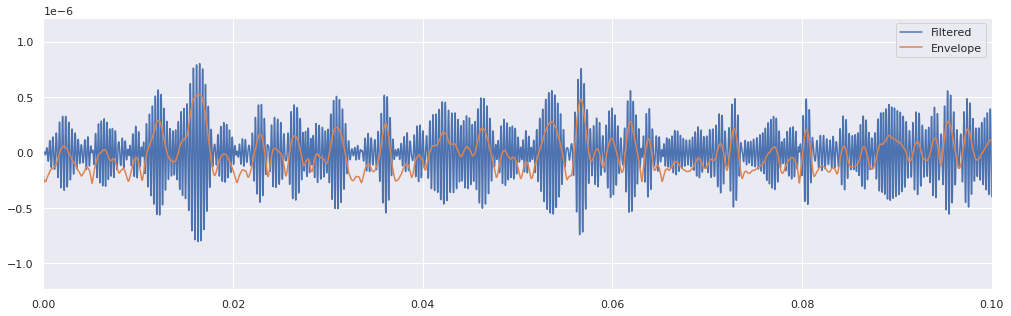

In [13]:
fig, ax = plt.subplots(1,1, figsize=(17, 5))

ax.plot(dataset[2]['time'].iloc[:N], filtered, label='Filtered')
ax.plot(dataset[2]['time'].iloc[:N], amplitude_envelope, label='Envelope')
ax.set_xlim(0,0.1)
ax.legend()

It is shown that by bandpass filtering the raw signal with the frequency band suggested by kurtogram and spectral kurtosis, the envelope spectrum analysis is able to reveal the fault signature at BPFO and its harmonics

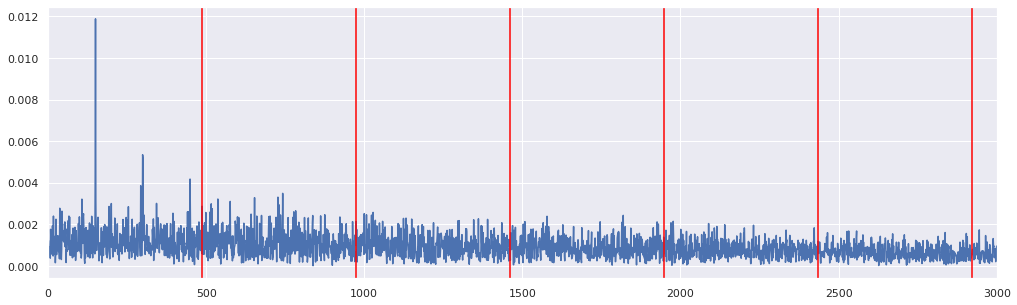

In [14]:
fig, ax = plt.subplots(1,1, figsize=(17, 5))
ax.plot(np.abs(np.fft.rfft(amplitude_envelope)), label='Filtered')
ax.set_xlim(0, 3000)
for i in range(15):
    ax.axvline(x=BPFO()*6*i, color='red')

### Transformation pipeline

In [15]:
p = 11
window_size = 2**p
stride = 2**p
transformations = ByNameFeatureSelector(['gs', 'sr'])
transformations = SplitIntoWindows(window_size=window_size, stride=stride)(transformations)
transformations = Windowed(
    KurtogramBandPassFiltering(
        numtaps=200,
        sampling_rate='sr'))(transformations)
transformations = Windowed(Envelope())(transformations)
transformations = Windowed(LifeStatistics())(transformations)
transformations = ConcatenateWindows()(transformations)




target_pipe = ByNameFeatureSelector(['label'])
target_pipe = TargetSplitIntoWindows(window_size=window_size, stride=stride)(target_pipe)


envelope_transformer = Transformer(
    transformerX=transformations.build(),
    transformerY=target_pipe.build())



### Raw pipeline

We will create also a pipeline which use only the raw features.

In [16]:
transformations = ByNameFeatureSelector(['gs'])

target_pipe = ByNameFeatureSelector(['label'])


raw_transformer = Transformer(
    transformerX=transformations.build(),
    transformerY=target_pipe.build())



### Fit the datasets

In [17]:
raw_transformer.fit(train_dataset)
envelope_transformer.fit(train_dataset)

In [18]:
envelope_transformer.transformerX.transform(train_dataset[0])

,gs_kurtosis,gs_skewness,gs_max,gs_min,gs_std,gs_peak,gs_impulse,gs_clearance,gs_rms,gs_shape,gs_crest
0,121.666406,9.872681,0.002220,8.597384e-20,0.000130,0.002220,93.640804,0.949046,0.000132,5.567147,16.820250
1,64.812143,7.255983,0.000915,1.537365e-19,0.000067,0.000915,55.899196,0.137297,0.000069,4.200907,13.306459
2,82.246846,7.997163,0.002483,5.683591e-19,0.000166,0.002483,60.982490,0.459379,0.000171,4.202697,14.510323
3,65.590429,7.536295,0.001501,3.576597e-19,0.000116,0.001501,59.434532,0.302254,0.000119,4.707669,12.625046
4,43.429550,6.122863,0.000562,1.257844e-19,0.000056,0.000562,35.824688,0.051568,0.000058,3.708191,9.660960
...,...,...,...,...,...,...,...,...,...,...,...
281,45.324861,6.268788,0.000847,4.459628e-19,0.000079,0.000847,40.902636,0.093485,0.000082,3.941088,10.378513
282,32.700733,5.576987,0.000614,4.023406e-20,0.000065,0.000614,38.163290,0.076349,0.000067,4.153389,9.188470
283,96.828261,8.693670,0.002727,8.220455e-19,0.000173,0.002727,83.298708,1.603350,0.000176,5.389727,15.455089
284,57.176999,6.780818,0.001143,6.848261e-19,0.000092,0.001143,53.644044,0.271630,0.000095,4.448971,12.057628


## Models
We will build a classifier to distinguish between the three classes:
* Normal
* Outer Race Fault
* Inner Race Fault



In [19]:
from rul_pm.models.gradientboosting import XGBoostModelClassifier
from rul_pm.iterators.iterators import WindowedDatasetIterator
from rul_pm.iterators.utils import true_values
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

### Compute class weights

In [20]:
train_iterator = WindowedDatasetIterator(
                 train_dataset,
                 window_size=1,
                 shuffle=False,
                 transformer=envelope_transformer)


In [21]:
y_train_true = np.squeeze(true_values(train_iterator))
classes = np.unique(y_train_true)
k_train = class_weight.compute_class_weight('balanced',
                                            classes=classes,
                                            y=y_train_true)
wt = dict(zip(classes, k_train))

In [22]:
X, y, sw = train_iterator.get_data()

In [23]:
train_iterator = WindowedDatasetIterator(
                 train_dataset,
                 window_size=1,
                 shuffle=False,
                 sample_weight=wt,
                 transformer=envelope_transformer)
test_iterator = WindowedDatasetIterator(
                 test_dataset,
                 window_size=1,
                 transformer=envelope_transformer)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from rul_pm.models.sklearn import SKLearnModel
from sklearn.linear_model import LogisticRegression
model = SKLearnModel(LogisticRegression(max_iter=150000))
model.fit(train_iterator)

In [25]:
model = XGBoostModelClassifier(use_label_encoder=False, 
                              num_class= 3,
                              objective='multi:softmax')
model.fit(train_iterator)

[17:56:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:

y_train_pred = model.predict(train_iterator)

In [27]:
accuracy_score(y_train_true, y_train_pred)

1.0

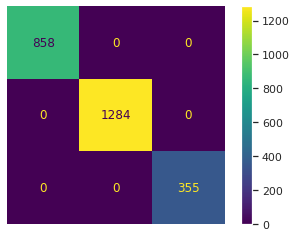

In [28]:
cm = confusion_matrix(y_train_true, y_train_pred)
fig, ax = plt.subplots()
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(ax=ax)
ax.axis('off');

In [32]:
y_true = true_values(test_iterator)

In [33]:
y_true = true_values(test_iterator)
y_pred = model.predict(test_iterator)
accuracy_score(y_true, y_pred)

0.7793427230046949

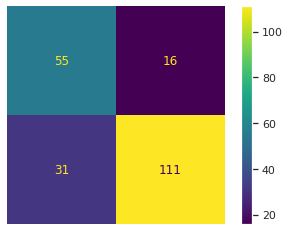

In [34]:
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(ax=ax)
ax.axis('off');
